In [1]:
import torch
from torchinfo import summary

## What we do in this TP?

In this TP, we will delve into the process of fine-tuning a pre-trained model for a specific task. Fine-tuning is a transfer learning method where the weights of an existing pre-trained model serve as the foundation for a new model. This approach is especially beneficial when the new task shares similarities with the original task for which the model was trained. By doing so, we can utilize the learned features of the pre-trained model, thereby reducing the need for extensive data and computational resources. 

We will tackle an object detection problem using the VOC dataset, which consists of approximately 5000 images for both training and validation. The images have been preprocessed to have (224x224) and contain only one bounding box around the object of interest. We will employ a Resnet18 model pre-trained on the ImageNet dataset as a feature extractor, and develop a model to detect the label and location of the object within the image. 



In [2]:
# Load data
train = torch.load('./data/train_data.pt')
validation = torch.load('./data/validation_data.pt')
test = torch.load('./data/test_data.pt')

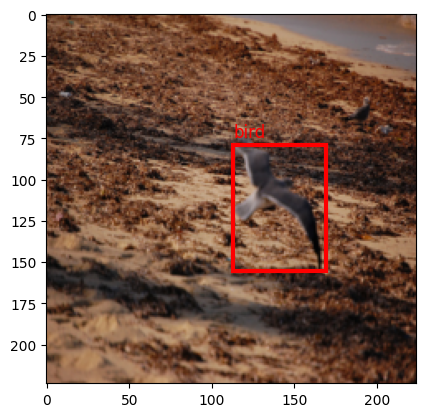

In [3]:
from utils import visualize_image

# Visualize a sample image
idx = 4055 # change this to visualize a different image
image, bbox, label = train[idx]
visualize_image(image, bbox, label)

Question: How is the data structured? What do the labels represent? What dimensions does an image have in the dataset?

In [5]:
# Normalize the data
from utils import normalize_data
from torch.utils.data import DataLoader

train_dataset = normalize_data(train)
validation_dataset = normalize_data(validation)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True) #TODO
validationloader = DataLoader(validation_dataset, batch_size=32, shuffle=True) #TODO

In object detection tasks, we need to develop both a classifier and a regressor. The classifier's role is to identify the object's label, while the regressor's role is to estimate the object's coordinates.

Our classifier and regressor are built as follows:

`Classifier`: It consists of two blocks, each containing a sequence of a Linear layer, a ReLU activation function, and a Dropout layer. This is followed by a final fully connected layer.

`Regressor`: It consists of two blocks of Linear layer and ReLU activation function, with the final block being a Linear layer and Sigmoid Activation function.


You are tasked to complete the model construction `ResNetObjectDetector` in the `model.py` file. Please note that the output from `self.features` has a shape of `(batch_size, 512)` and the number of classes is `20`. 

In [6]:
from model import ResnetObjectDetector
model = ResnetObjectDetector(nb_classes=20)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# Print model summary
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ResnetObjectDetector                          [32, 20]                  --
├─Sequential: 1-1                             [32, 512]                 --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          (73,984)
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          (73,984)
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [32, 128, 28, 28]         (230,144)
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]     

After completing the model definition, you can now write a train_loop and validation loop to train the model. Complete the function `train_loop` and `validation_loop` in `utils.py`.

[OPTIONAL] We will see how to use TensorBoard for monitoring the training process. If you are using VSCode, click on Launch TensorBoard Session, it will then install a tensorboard extension.

In [ ]:
from utils import train_loop
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# Train the model
now = datetime.now()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #TODO Define optimizer
epoch = 4 #TODO Define number of epochs
writer =  SummaryWriter(f'runs/tp6-object-recognition/{now.strftime("%Y-%m-%d_%H-%M-%S")}/')
losses, val_losses, acc, val_acc = train_loop(model=model, 
                                trainloader=trainloader, 
                                validationloader=validationloader, 
                                optimizer=optimizer, 
                                device=device, 
                                writer=writer, 
                                epochs=epoch)
writer.flush() # Write to disk
writer.close() # Close the writer

After the training process, you can generate plots for both the loss and accuracy curves (assuming you're not using TensorBoard). What conclusions can you draw from these visualizations?

By executing the cell below, you can examine the predictions made by the model. Do you see any potential for improving the model, and if so, how would you go about it?

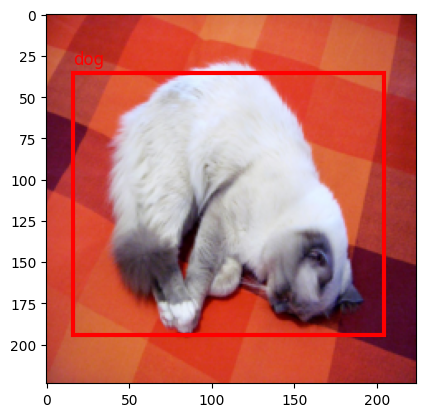

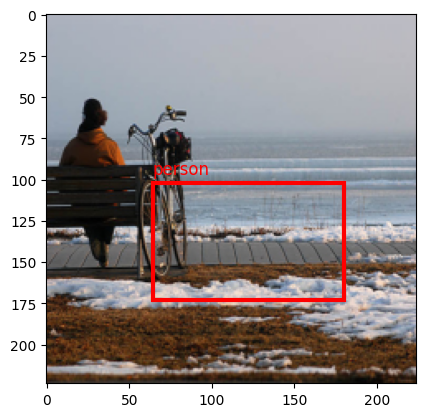

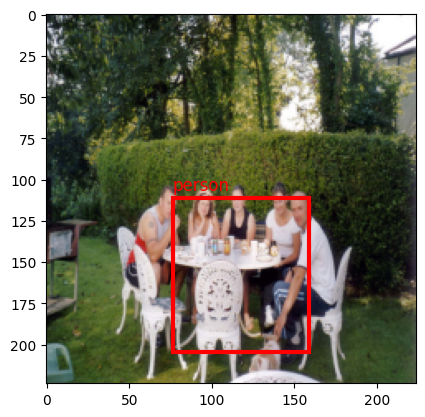

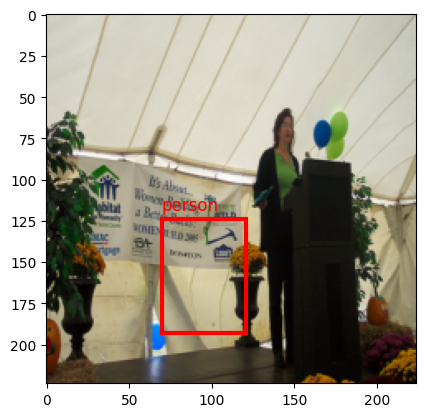

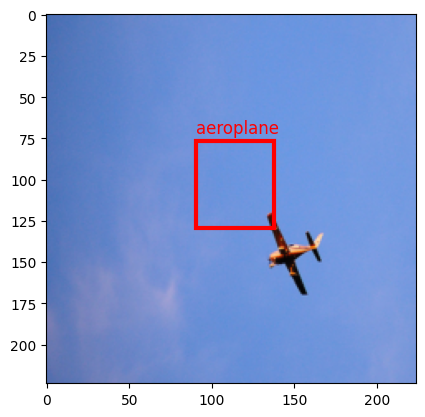

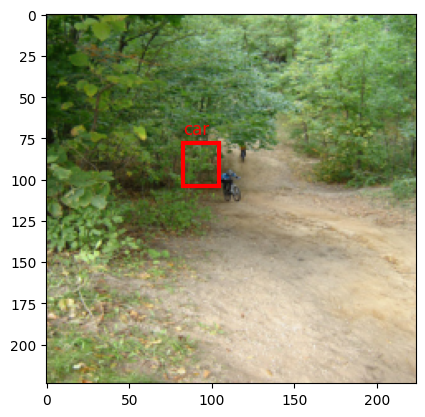

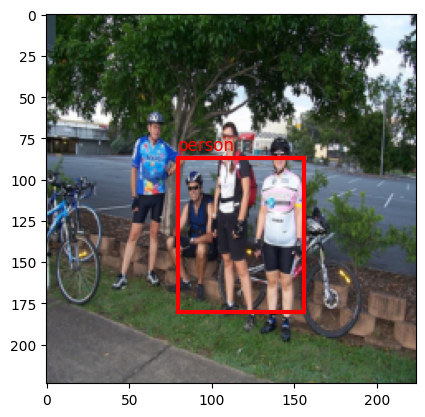

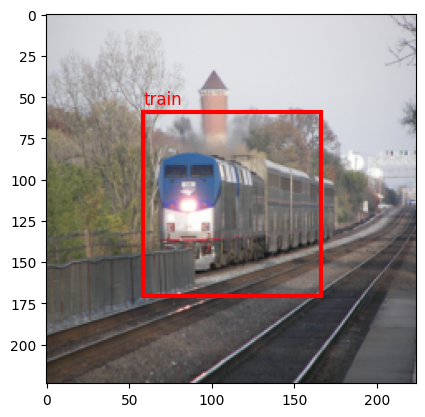

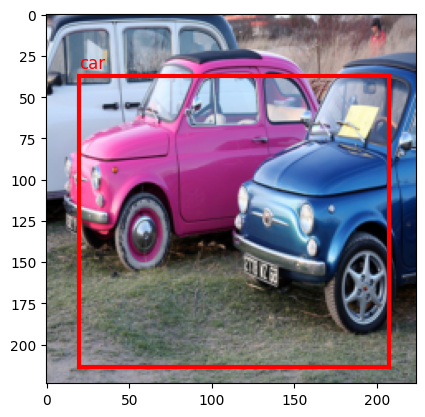

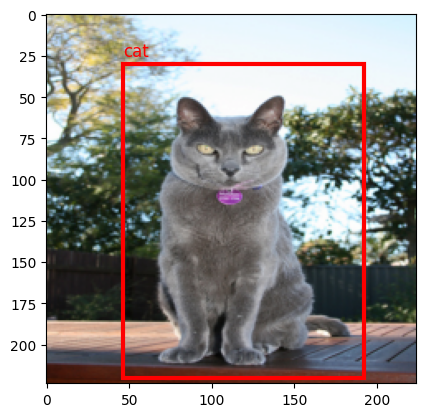

In [9]:
from utils import predict

# Normalize the test data
test_dataset = normalize_data(test)
# Predict on test data
for i in range(10,20):
    img = test_dataset[i][0]
    model.to('cpu')
    predict(model,image, show=True)